In [1]:
import numpy as np
import ctypes
from numpy.linalg import lstsq
from numba import jit, njit
import matplotlib.pyplot as plt

from ref_project import get_projection_matrix
from c_project import get_matrix
from FORBILD import forbild_sinogram

In [2]:
nx = 100
ny = 100
nnp = 128
nu = 128
lsd = 78.125
lso = 39.0625
dx = 0.25
dy = 0.25
du = 0.62

In [3]:
def forward_with_matrix(img, mat):
    img = img.reshape(nx*ny, 1)
    mat = mat.reshape(nnp*nu, nx*ny)

    proj = mat @ img

    return proj.reshape(nnp, nu)

def backward_from_projection(sino, mat):
    sino = sino.reshape(nnp*nu, 1)
    mat = mat.reshape(nnp*nu, nx*ny)
    
    img, residual, _, _ = lstsq(mat, sino, rcond=None)

    print("Residual: ", residual)

    return img.reshape(nx, ny)

In [4]:
sino = forbild_sinogram(nnp, nu, du, lsd, lso, True)

/tmp/ipykernel_3381549/2308346717.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sino = forbild_sinogram(nnp, nu, du, lsd, lso, True)
/tmp/ipykernel_3381549/2308346717.py:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  sino = forbild_sinogram(nnp, nu, du, lsd, lso, True)


In [ ]:
plt.imshow(sino, cmap='gray')

In [30]:
ref_mat = get_projection_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso)

ref_mat = np.transpose(ref_mat, (2, 3, 0, 1))

/home/ke/SGD/python/ref_project.py:165: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  x = projection_matrix(nx, ny, nnp, nu, dx, dy, srcs, dtvs, nuvs, beers_law)


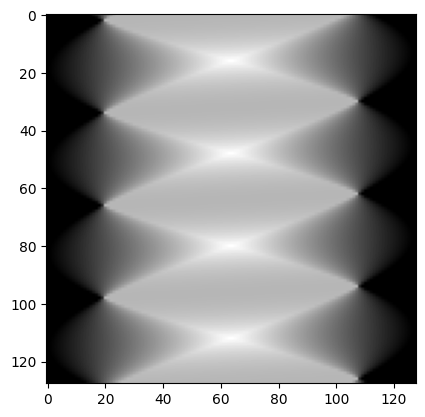

In [31]:
img = np.ones((nx, ny), dtype=np.float64)

proj = forward_with_matrix(img, ref_mat)

plt.imshow(proj, cmap='gray')

In [32]:
img = backward_from_projection(proj, ref_mat)

Residual:  [3.144e-27]


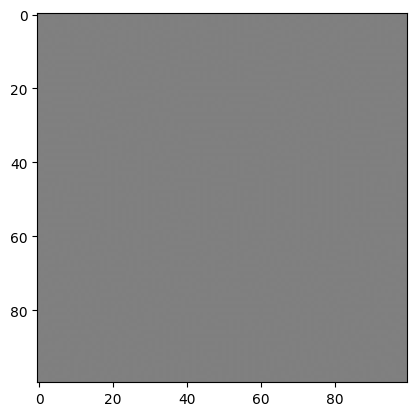

In [33]:
plt.imshow(img, cmap='gray', vmax=1.0001, vmin=0.9999)

In [34]:
mat = np.zeros((nnp, nu, nx, ny), dtype=np.float64)

get_matrix(nx, ny, nnp, nu, dx, dy, du, lsd, lso, mat)

In [35]:
img2 = backward_from_projection(proj, mat)

print(np.max(img2), np.min(img2))

Residual:  [0.001]
0.006464038326034832 -0.005837537773382674


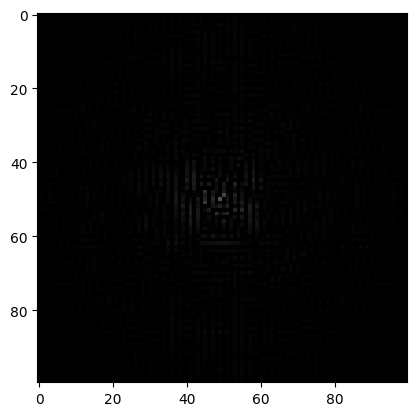

In [36]:
plt.imshow(img2, cmap='gray', vmax=2/100, vmin=0/100)